 # IBM DS0720EN - Capstone Project
 Chris.  -- https://github.com/chris-FR-GitHub/EDX-IBM

## <font color=blue>Q3 :Does the Complaint Type that you identified in response to question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?</font>

### Install the libraries (if necessary)

In [1]:
# !pip install --upgrade pip
# !pip install pandas-profiling 
# !pip install Folium
# !pip install scikit-learn
# !pip install xgboost

In [2]:
# !pip install xgboost

### Note

For this question, we will use the **BX_18v1.csv** PLUTO file located in the **input** folder.

### Load the complaints file and filter it to keep : <font color="red">'HEAT/HOT WATER' & 'HEATING'</font> types and <font color="red">'BRONX'</font> borough

In [3]:
# Import required libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as d

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

import pandas_profiling

from IPython.display import display
%matplotlib inline

pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 1000
np.set_printoptions(precision=3)

In [4]:
# Load the file in a dataframe
# As suggested in the "Ingest the NYC 311 Dataset" page : Parse the date fields by using the parse_dates option
df_heating_bronx = pd.read_csv('./input/NYC_311_Dataset.csv', parse_dates = ['created_date', 'closed_date'])

# merge  'HEAT/HOT WATER' & 'HEATING' type complaints
df_heating_bronx['complaint_type'].replace(
    to_replace=['HEAT/HOT WATER', 'HEATING'],
    value='HEATING/HOT WATER',
    inplace=True
)

# Keep only these 2 types
df_heating_bronx = df_heating_bronx[df_heating_bronx['complaint_type'] == 'HEATING/HOT WATER']

# Keep only the BRONX borough
df_heating_bronx = df_heating_bronx[df_heating_bronx['borough'] == 'BRONX']

# Convert ZIP as INT and process_days columns
import datetime as dt
today=dt.datetime.now() #.date()
df_heating_bronx['incident_zip'] = df_heating_bronx.incident_zip.fillna('00000').astype(int)
df_heating_bronx['process_days'] = (df_heating_bronx['closed_date'].fillna(today) - df_heating_bronx['created_date']).dt.days.astype(int) 
df_heating_bronx.head(2)



created_date  unique_key     complaint_type  incident_zip  \
0  2020-01-28 20:26:11    45492325  HEATING/HOT WATER         10462   
4  2020-01-28 14:10:04    45492347  HEATING/HOT WATER         10463   
7  2020-01-28 07:27:16    45493379  HEATING/HOT WATER         10462   
8  2020-01-28 07:21:15    45494446  HEATING/HOT WATER         10462   
13 2020-01-28 23:24:59    45496448  HEATING/HOT WATER         10473   

         incident_address       street_name address_type   city  \
0   2040 BRONXDALE AVENUE  BRONXDALE AVENUE      ADDRESS  BRONX   
4      2800 BAILEY AVENUE     BAILEY AVENUE      ADDRESS  BRONX   
7   2040 BRONXDALE AVENUE  BRONXDALE AVENUE      ADDRESS  BRONX   
8   2040 BRONXDALE AVENUE  BRONXDALE AVENUE      ADDRESS  BRONX   
13      2059 STORY AVENUE      STORY AVENUE      ADDRESS  BRONX   

                                                                                                                                                                                                                                                                                                                             resolution_description  \
0   The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.   
4   The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.   
7   The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.   
8   The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.   
13                                                                                                                                                                                        The following complaint conditions are still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection.   

   borough             latitude            longitude closed_date  \
0    BRONX               40.851              -73.867         NaT   
4    BRONX               40.873              -73.906         NaT   
7    BRONX               40.851              -73.867         NaT   
8    BRONX               40.851              -73.867         NaT   
13   BRONX               40.825              -73.854         NaT   

           location_type status  process_days  
0   RESIDENTIAL BUILDING   Open            10  
4   RESIDENTIAL BUILDING   Open            11  
7   RESIDENTIAL BUILDING   Open            11  
8   RESIDENTIAL BUILDING   Open            11  
13  RESIDENTIAL BUILDING   Open            10

In [5]:
# Get the dataframe size
df_heating_bronx.shape

(604848, 16)

### Check NaN values

In [6]:
# Count NaN values in each column
df_NaN_count = df_heating_bronx.isnull().sum(axis = 0)
df_NaN_count = df_NaN_count.to_frame()
df_NaN_count.rename(columns = {list(df_NaN_count)[0]:'Count'}, inplace=True)
df_NaN_count['NaN %'] = df_NaN_count['Count'] / len(df_heating_bronx)
df_NaN_count['NaN %'] = df_NaN_count['NaN %'].map(lambda x: "{0:.2f}%".format(x*100))
df_NaN_count

Count  NaN %
created_date                0  0.00%
unique_key                  0  0.00%
complaint_type              0  0.00%
incident_zip                0  0.00%
incident_address            1  0.00%
street_name                 1  0.00%
address_type             5803  0.96%
city                     5986  0.99%
resolution_description     29  0.00%
borough                     0  0.00%
latitude                 5986  0.99%
longitude                5986  0.99%
closed_date              2090  0.35%
location_type               0  0.00%
status                      0  0.00%
process_days                0  0.00%

We will use **incident_address** column value to merge with the PLUTO dataframe.  
Remove record with a NaN value in this column.  

In [7]:
df_heating_bronx.dropna(subset=['incident_address'], inplace=True)
df_heating_bronx.shape

(604847, 16)

In [8]:
df_heating_bronx['incident_address'].nunique()

22836

In [9]:
len(df_heating_bronx['incident_address'])

604847

We have 22836 distinct incident addresses, and a total of 604847 complaints.

### Compute the number of complaints by 'incident_address'

To add the number of compalinst to a specific PLUTO address, we compute the number of complaints by incident address.

In [10]:
df_complaints_count = df_heating_bronx.groupby(['incident_address']).size()
df_complaints_count = df_complaints_count.reset_index()
df_complaints_count.columns.values[1] = "Complaints"
df_complaints_count.head(10)

incident_address  Complaints
0      1 ADRIAN AVENUE          39
1      1 CAROLL STREET          18
2     1 DOROTHEA PLACE           1
3       1 EARHART LANE           2
4   1 EAST  169 STREET           1
5   1 EAST  198 STREET          31
6    1 EAST 169 STREET           1
7    1 EAST 198 STREET          42
8    1 EAST 212 STREET           3
9  1 METROPOLITAN OVAL          31

In [11]:
df_complaints_count.sort_values(by=['Complaints'],ascending=False).head(10)

incident_address  Complaints
15194             3810 BAILEY AVENUE        7113
333              1025 BOYNTON AVENUE        5774
8017        2090 EAST TREMONT AVENUE        3706
21713            888 GRAND CONCOURSE        3034
12389              2968 PERRY AVENUE        2917
7936             2074 WALLACE AVENUE        2578
403              1030 BOYNTON AVENUE        2482
11062     266 BEDFORD PARK BOULEVARD        2464
7726           2040 BRONXDALE AVENUE        2418
4025   1425 DR M L KING JR BOULEVARD        2268

In [12]:
df_complaints_count.nunique()

incident_address    22836
Complaints            483
dtype: int64

### Load the 'BRONX' PLUTO file

In [13]:
# Limit the Pluto database to the BRONX file
df_Bronx= pd.read_csv('./input/BX_18v1.csv')

# Limit the fields to the following:
#     Address, BldgArea, BldgDepth, BuiltFAR, 
#     CommFAR, FacilFAR, Lot, LotArea, LotDepth, NumBldgs, 
#     NumFloors, OfficeArea, ResArea, ResidFAR, RetailArea, 
#     YearBuilt, YearAlter1, ZipCode, YCoord, and XCoord.
df_Bronx = df_Bronx[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 
                     'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 
                     'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
                     'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]

# df_Bronx = df_Bronx.dropna()

df_Bronx.shape

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(89854, 20)

In [14]:
df_Bronx.head(5)

Address  BldgArea            BldgDepth             BuiltFAR  \
0  122 BRUCKNER BOULEVARD         0                0.000                0.000   
1  126 BRUCKNER BOULEVARD       752               16.000                0.050   
2  138 BRUCKNER BOULEVARD     39375              200.000                1.130   
3  144 BRUCKNER BOULEVARD     12500               85.000                5.000   
4  148 BRUCKNER BOULEVARD      8595               70.000                4.580   

               CommFAR             FacilFAR  Lot  LotArea  \
0                5.000                6.500    1    15000   
1                5.000                6.500    4    13770   
2                5.000                6.500   10    35000   
3                5.000                6.500   17     2500   
4                5.000                6.500   18     1875   

              LotDepth  NumBldgs            NumFloors  OfficeArea  ResArea  \
0              200.000         1                0.000           0        0   
1              100.000         2                1.000         272        0   
2              200.000         1                2.000           0        0   
3              100.000         1                5.000           0    12500   
4               75.000         1                5.000           0     6876   

              ResidFAR  RetailArea  YearBuilt  YearAlter1  \
0                6.020           0          0           0   
1                6.020           0       1931        1994   
2                6.020           0       1931           0   
3                6.020           0       1931        2001   
4                6.020        1719       1920        2009   

               ZipCode               YCoord               XCoord  
0           10,454.000          232,162.000        1,005,957.000  
1           10,454.000          232,156.000        1,006,076.000  
2           10,454.000          232,036.000        1,006,187.000  
3           10,454.000          232,033.000        1,006,299.000  
4           10,454.000          232,040.000        1,006,363.000

Convert the ZIP code as string.

In [15]:
# df_Bronx['ZipCode'] = df_Bronx['ZipCode'].astype(int).astype(str)

#### <font color="blue">Quizz - Can you determine the age of the building from the PLUTO dataset?</font>

We have the **'YearBuilt'** column. We should be able to compute the building Age column.  

In [16]:
df_Bronx['YearBuilt'].unique()

array([   0, 1931, 1920, 1967, 1963, 1973, 1984, 1915, 1990, 2003, 1925,
       1906, 1956, 2000, 2001, 1900, 1909, 1921, 1945, 1905, 1998, 1910,
       2005, 1993, 1907, 1961, 1935, 2004, 2002, 1957, 1901, 2015, 1964,
       1970, 1972, 1976, 1992, 1960, 1897, 1952, 1996, 1994, 1918, 1997,
       1913, 1951, 1924, 1926, 1927, 1891, 1899, 2006, 1890, 1986, 1932,
       1974, 1923, 2007, 1983, 1975, 2013, 1966, 1904, 1903, 1902, 2017,
       1995, 1933, 2008, 1991, 1969, 2016, 1889, 1888, 1887, 1930, 1912,
       2010, 2009, 1981, 1962, 1965, 1880, 1958, 1936, 1955, 2012, 1895,
       1886, 1989, 1938, 1940, 1928, 1911, 1917, 1954, 1988, 1950, 1914,
       2011, 1908, 1929, 1959, 1978, 2014, 1971, 1941, 1896, 1953, 1947,
       1948, 1922, 1949, 1919, 1979, 1980, 1937, 1916, 1944, 1800, 1999,
       1977, 1943, 1968, 1987, 1934, 1982, 1939, 1942, 1985, 1946, 1898,
       1850, 1892, 1812, 1780, 1884, 1853, 1885, 1883, 1878, 1849, 1868,
       1870, 1893, 1848], dtype=int64)

We have some 0 in the column.

In [17]:
(df_Bronx['YearBuilt'] == 0).sum()

6367

We will replace this value by the current year to compute the age column.

In [18]:
#df_Bronx = df_Bronx[df_Bronx['YearBuilt'] != 0]

current_year = int(d.datetime.now().year)

df_Bronx['YearBuilt'].replace(
    to_replace=[0],
    value=current_year,
    inplace=True
)

In [19]:
# Compute the Age Column
df_Bronx['Age'] = current_year - df_Bronx['YearBuilt']
df_Bronx.head(5)

Address  BldgArea            BldgDepth             BuiltFAR  \
0  122 BRUCKNER BOULEVARD         0                0.000                0.000   
1  126 BRUCKNER BOULEVARD       752               16.000                0.050   
2  138 BRUCKNER BOULEVARD     39375              200.000                1.130   
3  144 BRUCKNER BOULEVARD     12500               85.000                5.000   
4  148 BRUCKNER BOULEVARD      8595               70.000                4.580   

               CommFAR             FacilFAR  Lot  LotArea  \
0                5.000                6.500    1    15000   
1                5.000                6.500    4    13770   
2                5.000                6.500   10    35000   
3                5.000                6.500   17     2500   
4                5.000                6.500   18     1875   

              LotDepth  NumBldgs            NumFloors  OfficeArea  ResArea  \
0              200.000         1                0.000           0        0   
1              100.000         2                1.000         272        0   
2              200.000         1                2.000           0        0   
3              100.000         1                5.000           0    12500   
4               75.000         1                5.000           0     6876   

              ResidFAR  RetailArea  YearBuilt  YearAlter1  \
0                6.020           0       2020           0   
1                6.020           0       1931        1994   
2                6.020           0       1931           0   
3                6.020           0       1931        2001   
4                6.020        1719       1920        2009   

               ZipCode               YCoord               XCoord  Age  
0           10,454.000          232,162.000        1,005,957.000    0  
1           10,454.000          232,156.000        1,006,076.000   89  
2           10,454.000          232,036.000        1,006,187.000   89  
3           10,454.000          232,033.000        1,006,299.000   89  
4           10,454.000          232,040.000        1,006,363.000  100

In [20]:
# We can drop the YearBuilt column
df_Bronx.drop(['YearBuilt'], axis=1, inplace=True)

In [21]:
df_Bronx.head(5)

Address  BldgArea            BldgDepth             BuiltFAR  \
0  122 BRUCKNER BOULEVARD         0                0.000                0.000   
1  126 BRUCKNER BOULEVARD       752               16.000                0.050   
2  138 BRUCKNER BOULEVARD     39375              200.000                1.130   
3  144 BRUCKNER BOULEVARD     12500               85.000                5.000   
4  148 BRUCKNER BOULEVARD      8595               70.000                4.580   

               CommFAR             FacilFAR  Lot  LotArea  \
0                5.000                6.500    1    15000   
1                5.000                6.500    4    13770   
2                5.000                6.500   10    35000   
3                5.000                6.500   17     2500   
4                5.000                6.500   18     1875   

              LotDepth  NumBldgs            NumFloors  OfficeArea  ResArea  \
0              200.000         1                0.000           0        0   
1              100.000         2                1.000         272        0   
2              200.000         1                2.000           0        0   
3              100.000         1                5.000           0    12500   
4               75.000         1                5.000           0     6876   

              ResidFAR  RetailArea  YearAlter1              ZipCode  \
0                6.020           0           0           10,454.000   
1                6.020           0        1994           10,454.000   
2                6.020           0           0           10,454.000   
3                6.020           0        2001           10,454.000   
4                6.020        1719        2009           10,454.000   

                YCoord               XCoord  Age  
0          232,162.000        1,005,957.000    0  
1          232,156.000        1,006,076.000   89  
2          232,036.000        1,006,187.000   89  
3          232,033.000        1,006,299.000   89  
4          232,040.000        1,006,363.000  100

####  <font color="blue">We can create the **Age** column from the **YearBuilt** one.</font>  

### Merge the PLUTO dataset with the number of complaints

In [22]:
df_Bronx.shape

(89854, 20)

In [23]:
df_Bronx = pd.merge(df_Bronx, 
                    df_complaints_count,
                    left_on="Address",
                    right_on="incident_address",
                    how="left")

df_Bronx.head(5)

Address  BldgArea            BldgDepth             BuiltFAR  \
0  122 BRUCKNER BOULEVARD         0                0.000                0.000   
1  126 BRUCKNER BOULEVARD       752               16.000                0.050   
2  138 BRUCKNER BOULEVARD     39375              200.000                1.130   
3  144 BRUCKNER BOULEVARD     12500               85.000                5.000   
4  148 BRUCKNER BOULEVARD      8595               70.000                4.580   

               CommFAR             FacilFAR  Lot  LotArea  \
0                5.000                6.500    1    15000   
1                5.000                6.500    4    13770   
2                5.000                6.500   10    35000   
3                5.000                6.500   17     2500   
4                5.000                6.500   18     1875   

              LotDepth  NumBldgs            NumFloors  OfficeArea  ResArea  \
0              200.000         1                0.000           0        0   
1              100.000         2                1.000         272        0   
2              200.000         1                2.000           0        0   
3              100.000         1                5.000           0    12500   
4               75.000         1                5.000           0     6876   

              ResidFAR  RetailArea  YearAlter1              ZipCode  \
0                6.020           0           0           10,454.000   
1                6.020           0        1994           10,454.000   
2                6.020           0           0           10,454.000   
3                6.020           0        2001           10,454.000   
4                6.020        1719        2009           10,454.000   

                YCoord               XCoord  Age        incident_address  \
0          232,162.000        1,005,957.000    0                     NaN   
1          232,156.000        1,006,076.000   89                     NaN   
2          232,036.000        1,006,187.000   89                     NaN   
3          232,033.000        1,006,299.000   89  144 BRUCKNER BOULEVARD   
4          232,040.000        1,006,363.000  100  148 BRUCKNER BOULEVARD   

            Complaints  
0                  nan  
1                  nan  
2                  nan  
3                5.000  
4               13.000

In [24]:
df_Bronx.shape

(89854, 22)

In [25]:
print('We matched',df_Bronx['incident_address'].count(), 
      'of the', df_complaints_count['incident_address'].count(), 'incident adresses.') 

We matched 17347 of the 22836 incident adresses.


In [26]:
# replace NaN Complaints value by 0
df_Bronx['Complaints'] = df_Bronx['Complaints'].fillna(0)
df_Bronx['HasComplaint'] = np.where(df_Bronx['Complaints']==0, 0, 1)
# remove the incident_address
df_Bronx.drop(['incident_address'], axis=1, inplace=True)

We have 2 different targets depending if we wnat the model the number of complaints **OR** if there has been a complaint.

### Check the new data frame using the pandas_profiling package

In [27]:

prof = pandas_profiling.ProfileReport(df_Bronx)
#prof
prof.to_notebook_iframe()

### <font color="blue">Quizz : Which of the following methodologies can you use to identify whether any relationship exist between the building characteristics and the number of complaints?</font>

### Feature Selection Using the **Pearson correlation**

In [28]:
# using Pearson correlation and sns.heatmap
cor = df_Bronx.corr(method='pearson')

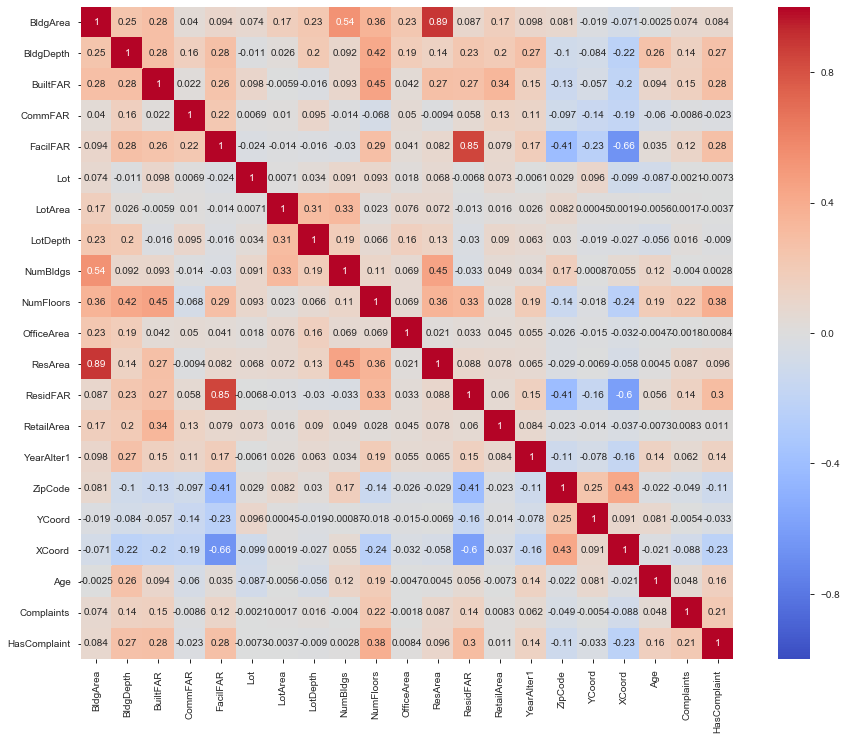

In [29]:
#draw a heatmap
plt.figure(figsize=(16,12))

sns.heatmap(cor, annot = True, cmap='coolwarm', square=True,vmax=1, vmin=-1)
#Correct a seaborn bug
# This was a matplotlib regression introduced in 3.1.1 which has been fixed in 3.1.2 (still forthcoming). 
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t)

# show
plt.show()

In [30]:
#Correlation with output variable
cor_complaints = abs(cor["Complaints"])
#Selecting top 5 correlated features.
corr_features = cor_complaints.sort_values(ascending=False).drop(labels=['Complaints', 'HasComplaint']).head(10)
corr_features

NumFloors                   0.223
BuiltFAR                    0.152
BldgDepth                   0.144
ResidFAR                    0.136
FacilFAR                    0.117
XCoord                      0.088
ResArea                     0.087
BldgArea                    0.074
YearAlter1                  0.062
ZipCode                     0.049
Name: Complaints, dtype: float64

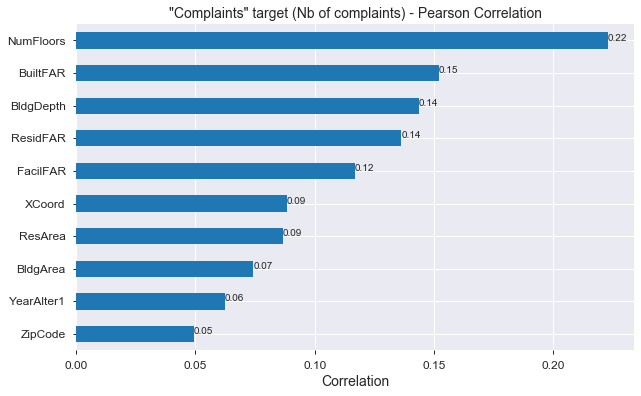

In [31]:
corr_features.plot(kind='barh', figsize=(10, 6),fontsize=12)
plt.xlabel('Correlation',fontsize=14)
plt.title('"Complaints" target (Nb of complaints) - Pearson Correlation', fontsize=14)
plt.gca().invert_yaxis()
[plt.text(v, i, '{0:.2f}'.format(v)) for i, v in enumerate(corr_features)];
plt.show()

####  <font color="blue">Using Pearson correlation, there seems to have a correlation between : NumFloors, BuiltFAR, BldgDepth, ResidFAR, FacilFAR and the **_number of complaints_**.</font>  

In [32]:
#Correlation with 2nd variable
cor_hascomplaint = abs(cor["HasComplaint"])
#Selecting top 5 correlated features.
corr_features_hascomplaint = cor_hascomplaint.sort_values(ascending=False).drop(labels=['Complaints', 'HasComplaint']).head(10)
corr_features_hascomplaint

NumFloors                   0.384
ResidFAR                    0.298
FacilFAR                    0.278
BuiltFAR                    0.275
BldgDepth                   0.271
XCoord                      0.225
Age                         0.159
YearAlter1                  0.138
ZipCode                     0.113
ResArea                     0.096
Name: HasComplaint, dtype: float64

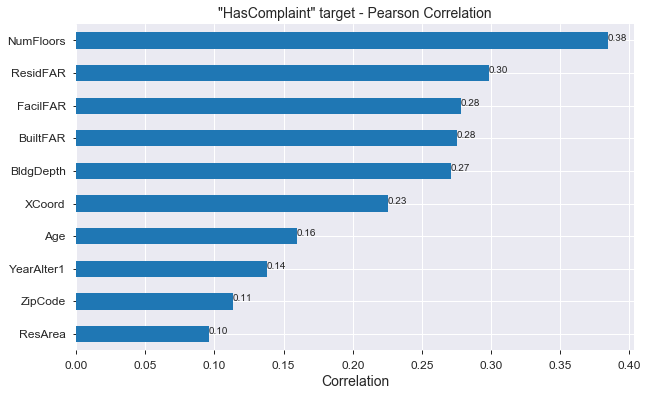

In [33]:
corr_features_hascomplaint.plot(kind='barh', figsize=(10, 6),fontsize=12)
plt.xlabel('Correlation',fontsize=14)
plt.title('"HasComplaint" target - Pearson Correlation', fontsize=14)
plt.gca().invert_yaxis()
[plt.text(v, i, '{0:.2f}'.format(v)) for i, v in enumerate(corr_features_hascomplaint)];
plt.show()

####  <font color="blue">If we check if there will be a complaint (not the number of complaints), there seems to have a stronger correlation with the same features.</font>  

### Feature Selection Using **Random forest**

In [34]:
# Filter rows with missing values
df_Bronx = df_Bronx.dropna(axis=0)

In [35]:
features = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 
                     'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 
                     'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
                     'Age', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']


# Choose target and features
y = df_Bronx.Complaints
# features
X = df_Bronx[features]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)


In [36]:
# use SelectFromModel



# use SelectFromModel to get the list of features
# sel = SelectFromModel( RandomForestRegressor(random_state=1) )
# sel.fit(train_X, train_y)

# selected_feat= train_X.columns[(sel.get_support())]
# len(selected_feat)

# Print the names of the most important features
# for feature_list_index in sel.get_support(indices=True):
#     print(features[feature_list_index])

In [37]:
# use the RandomForestRegressor model
forest_model = RandomForestRegressor(n_estimators=100,
                              random_state=0)
forest_model.fit(train_X, train_y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [38]:
# get the feature importance list
feature_importances = pd.DataFrame(forest_model.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances

importance
ResArea                   0.174
YCoord                    0.131
XCoord                    0.118
BuiltFAR                  0.115
LotArea                   0.076
BldgArea                  0.063
Age                       0.058
Lot                       0.058
OfficeArea                0.044
LotDepth                  0.038
BldgDepth                 0.036
ZipCode                   0.026
YearAlter1                0.018
RetailArea                0.016
ResidFAR                  0.010
NumFloors                 0.009
FacilFAR                  0.006
NumBldgs                  0.002
CommFAR                   0.001

In [39]:
# importances = forest_model.feature_importances_
# indices = np.argsort(importances)[::-1]
# for f in range(train_X.shape[1]):
#     print("%d. %s %d (%f)" % (f + 1, features[indices[f]], indices[f], importances[indices[f]]))

####  <font color="blue">Using the RandomForestRegressor class, we are also able to determine the features importance.</font>  

### Feature Importance function from XGBoost algorithm

In [40]:
# same start than the Random forest
features = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 
                     'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 
                     'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 
                     'Age', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']


# Choose target and features
y = df_Bronx.Complaints
# features
X = df_Bronx[features]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [41]:
# use the XGBRegressor class
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0.045,                 
                 learning_rate=0.07,
                 max_depth=20,
                 min_child_weight=1.5,
                 n_estimators=300,                                                                    
                 reg_alpha=0.65,
                 reg_lambda=0.45,
                 subsample=0.95)
xgb_model.fit(train_X, train_y)

[18:12:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.045,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=20, min_child_weight=1.5, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.65, reg_lambda=0.45, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=1)

In [42]:
# get the feature importance list
feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

importance
NumFloors                 0.151
ResArea                   0.094
OfficeArea                0.078
XCoord                    0.074
LotArea                   0.070
BuiltFAR                  0.067
YCoord                    0.066
LotDepth                  0.065
RetailArea                0.045
BldgArea                  0.045

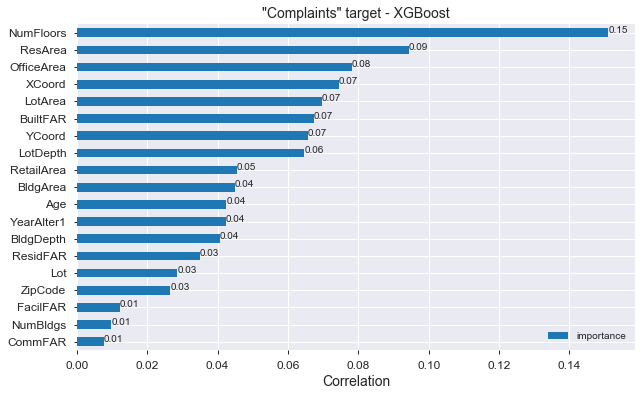

In [43]:
feature_importances.plot(kind='barh', figsize=(10, 6),fontsize=12)
plt.xlabel('Correlation',fontsize=14)
plt.title('"Complaints" target - XGBoost', fontsize=14)
plt.gca().invert_yaxis()
[plt.text(v, i, '{0:.2f}'.format(v)) for i, v in enumerate(feature_importances['importance'])];
plt.show()

## <font color=blue>Q3 Conclusion</font>

<font color="blue">Using the Pearson correlation we found that the **NumFloors**, **BuiltFAR**, **BldgDepth**, **ResidFAR**, **FacilFAR**, **XCoord** and **ResArea** features have a correlation with the **number of complaints**.</font>  
<font color="blue">We find again the **NumFloors**, **ResArea**, **XCoord**, **BuiltFAR** in the XGBoost result and OfficeArea, LotArea. </font>  

